# Poisson Regression

In [1]:
%run -m ipy_startup
%matplotlib inline
from scipy.stats import poisson

In [18]:
# Generate random data to model
np.random.seed(1)
n, n_var = 10000, 5
#n, n_class, n_var = 10000, 4, 5

X = np.random.randn(n, n_var)

b_act = .25*np.random.randn(n_var)
b_int = -.3
p = np.exp(b_int + np.dot(X, b_act))

y = np.array([poisson.rvs(v, size=1)[0] for v in p])

X.shape, y.shape

((10000, 5), (10000,))

In [19]:
pd.Series(np.dot(X, b_act)).describe()

count    10000.000000
mean        -0.007391
std          0.395242
min         -1.341441
25%         -0.273490
50%         -0.007805
75%          0.260335
max          1.604890
dtype: float64

In [20]:
pd.Series(y).value_counts().head()

0    4729
1    3374
2    1343
3     412
4     108
dtype: int64

In [21]:
pd.Series(y).describe()

count    10000.000000
mean         0.790300
std          0.940433
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          7.000000
dtype: float64

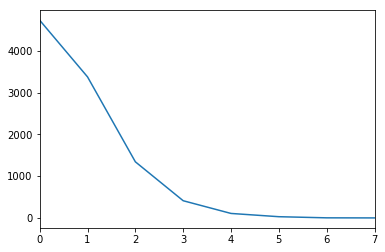

In [22]:
pd.Series(y).value_counts().sort_index().plot()

In [34]:
from ml.scipy import optimize, models
param_names = ['X{}'.format(i) for i in range(n_var)]
constraints = optimize.ScipyConstraints()
constraints.add_gtez('X0')
constraints.add_gte('X1', 'X2')
constraints.add_gte('X2', 'X3')
#constraints.add_gtev('X4', 5.0)

model = (
    models.ScipyPoissonRegressionModelBuilder()
    .add_linear_params(param_names)
    .add_intercept()
    .add_constraints(constraints)
    .build()
)


In [35]:
%%time
est = optimize.ScipyRegressor(model, analytical_gradients=True, monitor_gradient=True, raise_on_failure=False)
est.fit(X, y)

CPU times: user 146 ms, sys: 9.23 ms, total: 156 ms
Wall time: 43.6 ms


In [36]:
print(est.get_fit_summary())

Optimization converged successfully:

    Success: True
    Status Code: 0
    Message: Optimization terminated successfully.
    Number of iterations: 4
    Number of function evaluations: 4
    Objective Function Value: 1.159054553872002
    


In [37]:
est.get_gradient_error_history()

array([  2.78258116e-08,   2.33472256e-08,   2.99283842e-08,
         2.99283842e-08])

In [38]:
est.fit_

     fun: 1.159054553872002
     jac: array([  5.16114384e-04,   1.62775427e-01,   6.58392303e-02,
        -6.56859256e-02,   4.29368576e-04,   6.71805084e-05])
 message: 'Optimization terminated successfully.'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ -2.74542286e-01,   2.23585903e-17,  -2.75090344e-02,
        -2.75090344e-02,  -2.96067994e-01,  -4.36885656e-02])

In [39]:
d_inf = est.inference()
d_inf

{'intercept': OrderedDict([('intercept', -0.27454228605891895)]), 'linear': OrderedDict([('X0', 2.2358590261619651e-17), ('X1', -0.027509034392622297), ('X2', -0.027509034392622304), ('X3', -0.29606799441034859), ('X4', -0.04368856558820787)]), 'fit': OrderedDict()}

In [40]:
b_int, d_inf['intercept']

(-0.3, intercept   -0.274542
 dtype: float64)

In [41]:
b_act

array([-0.22347121, -0.09297245,  0.04883249, -0.31410596, -0.04702415])

In [42]:
def compare(v_est, v_act):
    plt.scatter(v_est, v_act)
    vmin, vmax = v_act.min(), v_act.max()
    plt.xlim(vmin - .1, vmax + .1)
    plt.ylim(vmin - .1, vmax + .1)

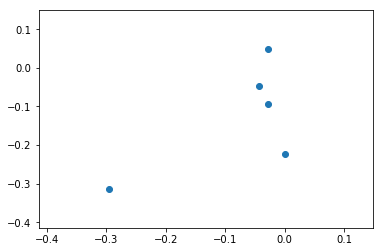

In [43]:
compare(pd.Series(d_inf['linear']), b_act)

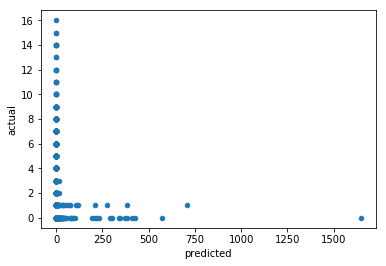

In [17]:
pd.DataFrame({
    'predicted': est.predict(X),
    'actual': y
}).plot(kind='scatter', x='predicted', y='actual')

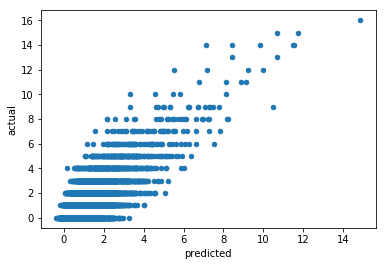

In [57]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
pd.DataFrame({
    'predicted': GradientBoostingRegressor().fit(X, y).predict(X),
    'actual': y
}).plot(kind='scatter', x='predicted', y='actual')